# Sentinel Hub's cloud detector

This example notebook shows how to perform cloud classification and cloud masking on an individual Sentinel-2 scene obtained with Sentinel Hub's WMS or WCS services ([sentinelhub-py python package](https://github.com/sentinel-hub/sentinelhub-py)).

### Prerequisite: Sentinel Hub account

In order to use Sentinel Hub services you will need a Sentinel Hub account. If you do not have one yet, you can create a free trial account at [Sentinel Hub webpage](https://services.sentinel-hub.com/oauth/subscription). If you are a researcher you can even apply for a free non-commercial account at [ESA OSEO page](https://earth.esa.int/aos/OSEO).

Once you have the account set up, write down your **_instance ID_** (alpha-numeric code of length 36) in the next cell.

In [12]:
INSTANCE_ID = '0133b8d1-aaed-4d7d-b857-afae446ee2cb'

In order to create a cloud mask using Sentinel-Hub services, you also need to provide **_LAYERS_** parameter to the OGC services. Pick any from you configuration, or create a new one.

In [13]:
LAYER_NAME = 'TRUE_COLOR'  # e.g. TRUE-COLOR-S2-L1C

#### Imports 

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import datetime

import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import WmsRequest, BBox, CRS, MimeType, CustomUrlParam, get_area_dates
from s2cloudless import S2PixelCloudDetector, CloudMaskRequest

In [5]:
def overlay_cloud_mask(image, mask=None, factor=1./255, figsize=(15, 15), fig=None):
    """
    Utility function for plotting RGB images with binary mask overlayed.
    """
    if fig == None:
        plt.figure(figsize=figsize)
    rgb = np.array(image)
    plt.imshow(rgb * factor)
    if mask is not None:
        cloud_image = np.zeros((mask.shape[0], mask.shape[1], 4), dtype=np.uint8)
        cloud_image[mask == 1] = np.asarray([255, 255, 0, 100], dtype=np.uint8)
        plt.imshow(cloud_image)

In [6]:
def plot_probability_map(rgb_image, prob_map, factor=1./255, figsize=(15, 30)):
    """
    Utility function for plotting a RGB image and its cloud probability map next to each other. 
    """
    plt.figure(figsize=figsize)
    plot = plt.subplot(1, 2, 1)
    plt.imshow(rgb_image * factor)
    plot = plt.subplot(1, 2, 2)
    plot.imshow(prob_map, cmap=plt.cm.inferno)

In [7]:
def plot_cloud_mask(mask, figsize=(15, 15), fig=None):
    """
    Utility function for plotting a binary cloud mask.
    """
    if fig == None:
        plt.figure(figsize=figsize)
    plt.imshow(mask, cmap=plt.cm.gray)

In [8]:
def plot_previews(data, dates, cols=4, figsize=(15, 15)):
    """
    Utility to plot small "true color" previews.
    """
    width = data[-1].shape[1]
    height = data[-1].shape[0]
    
    rows = data.shape[0] // cols + (1 if data.shape[0] % cols else 0)
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
    for index, ax in enumerate(axs.flatten()):
        if index < data.shape[0]:
            caption = '{}: {}'.format(index, dates[index].strftime('%Y-%m-%d'))
            ax.set_axis_off()
            ax.imshow(data[index] / 255., vmin=0.0, vmax=1.0)
            ax.text(0, -2, caption, fontsize=12, color='g')
        else:
            ax.set_axis_off()

## Example scenes: Acatenango and Volcan Fuego (Guatemala) in December 2017

Acatenango area in Guatemala is well known for its coffee plantations. At the altitute of about 2000 m and given it’s climate, it is often veiled in clouds. First, lets define the bounding box for the area of interest.

As of `sentinelhub` version 2.0.0 the order of coordinates for BBOX in WGS84 has to be given in longitude, latitude order.

In [29]:
bbox_coords_wgs84 = [-90.9216499, 14.4190528, -88.8186531, 16.5520163]

In [30]:
bounding_box = BBox(bbox_coords_wgs84, crs=CRS.WGS84)

### Download all available Sentinel-2 images of Acatenango and Volcan Fuego taken in December 2017

We'll use WMS requests of [sentinelhub-py python package](https://github.com/sentinel-hub/sentinelhub-py) to download the RGB (true color) images out of all 13 Sentinel-2 bands. We will only specify the width of the image and let the height to be set automatically so that the width/height ratio will best fit the bounding box.

In [31]:
wms_true_color_request = WmsRequest(layer=LAYER_NAME,
                                    bbox=bounding_box, 
                                    time=('2017-10-01', '2017-12-31'), 
                                    width=600, height=None,
                                    image_format=MimeType.PNG,
                                    instance_id=INSTANCE_ID)

In [32]:
wms_true_color_imgs = wms_true_color_request.get_data()

Let's see the previews:

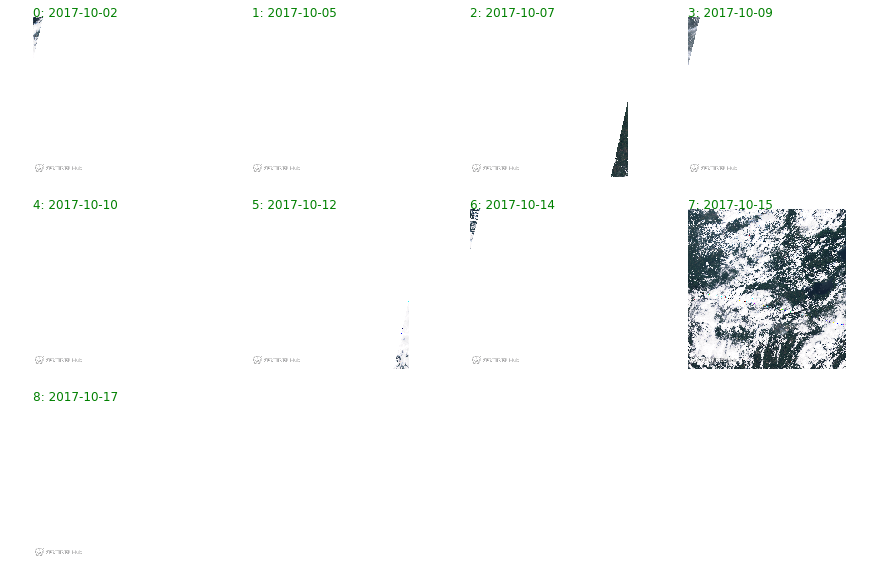

In [34]:
plot_previews(np.asarray(wms_true_color_imgs[1:10]), wms_true_color_request.get_dates(), cols=4, figsize=(15, 10))

The bands needed by the cloud detector to make its predictions are `B01`, `B02`, `B04`, `B05`, `B08`, `B8A`, `B09`, `B10`, `B11`, `B12`. We will use Sentinel Hub API to construct a custom script that will return just those needed bands:

In [18]:
bands_script = 'return [B01,B02,B04,B05,B08,B8A,B09,B10,B11,B12]'

In [19]:
wms_bands_request = WmsRequest(layer=LAYER_NAME,
                               custom_url_params={CustomUrlParam.EVALSCRIPT: bands_script},
                               bbox=bounding_box, 
                               time=('2017-02-01', '2017-12-31'), 
                               width=600, height=None,
                               image_format=MimeType.TIFF_d32f,
                               instance_id=INSTANCE_ID)

In [20]:
wms_bands = wms_bands_request.get_data()

### Initialize the cloud detector and make classification of downloaded scenes

We can specify the following arguments in the initialization of a `S2PixelCloudDetector`:
 * `threshold` - cloud probability threshold value. All pixels with cloud probability above threshold value are masked as cloudy pixels. Default is `0.4`.
 * `all_bands` - Flag specifying that input images will consists of all 13 Sentinel-2 bands. It has to be set to `True` if we would download all bands. If you define a layer that would return only 10 bands, then this parameter should be set to `False`.
 * `average_over` - Size of the disk in pixels for performing convolution (averaging probability over pixels). For this resolution `4` is appropriate. 
 * `dilation_size` - Size of the disk in pixels for performing dilation.  For this resolution `2` is appropriate. 

In [21]:
cloud_detector = S2PixelCloudDetector(threshold=0.4, average_over=4, dilation_size=2)

#### Run the classification

There are two possibilities:
 * `get_cloud_probability_maps` will return cloud probability map
 * `get_cloud_masks` will return binary cloud masks

In [22]:
cloud_probs = cloud_detector.get_cloud_probability_maps(np.array(wms_bands))

In [23]:
cloud_masks = cloud_detector.get_cloud_masks(np.array(wms_bands))

### Visualize the results

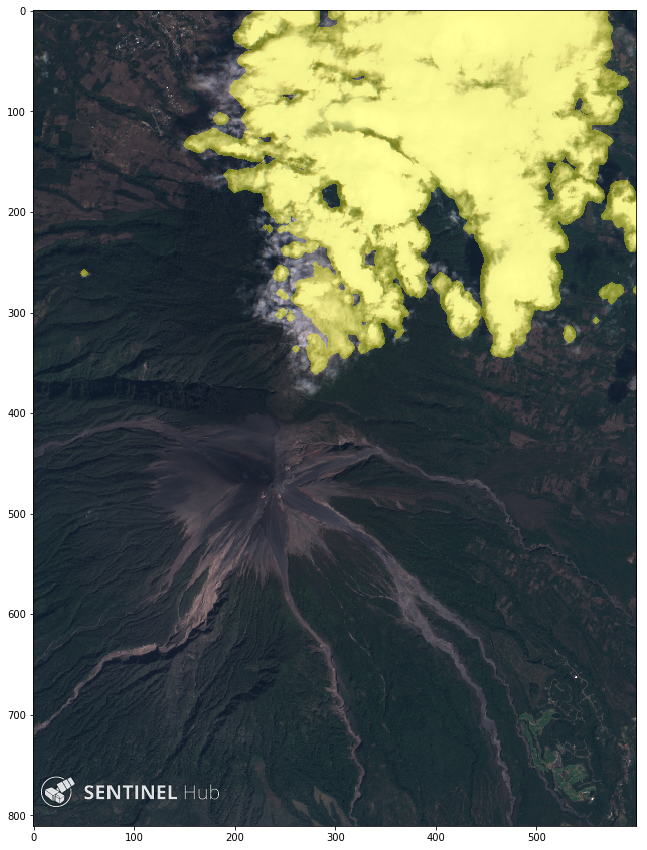

In [24]:
image_idx = 0
overlay_cloud_mask(wms_true_color_imgs[image_idx], cloud_masks[image_idx])

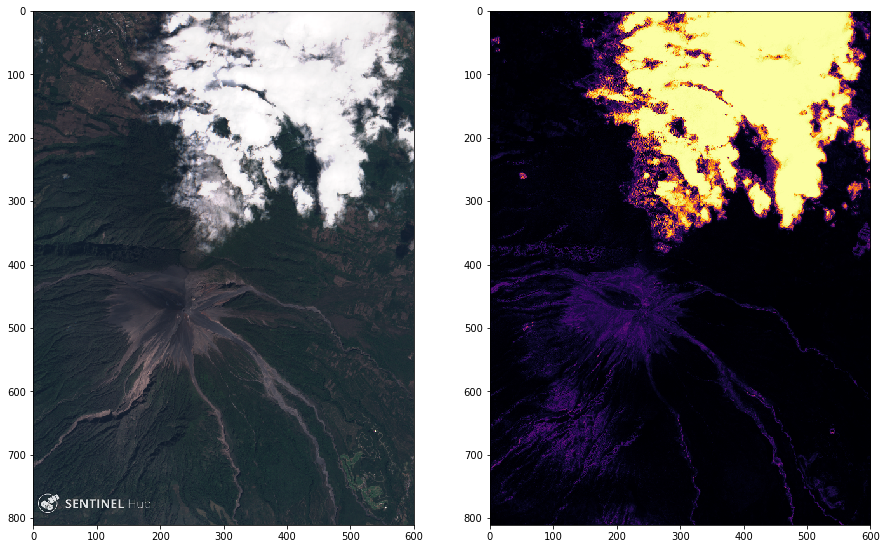

In [25]:
plot_probability_map(wms_true_color_imgs[image_idx], cloud_probs[image_idx])

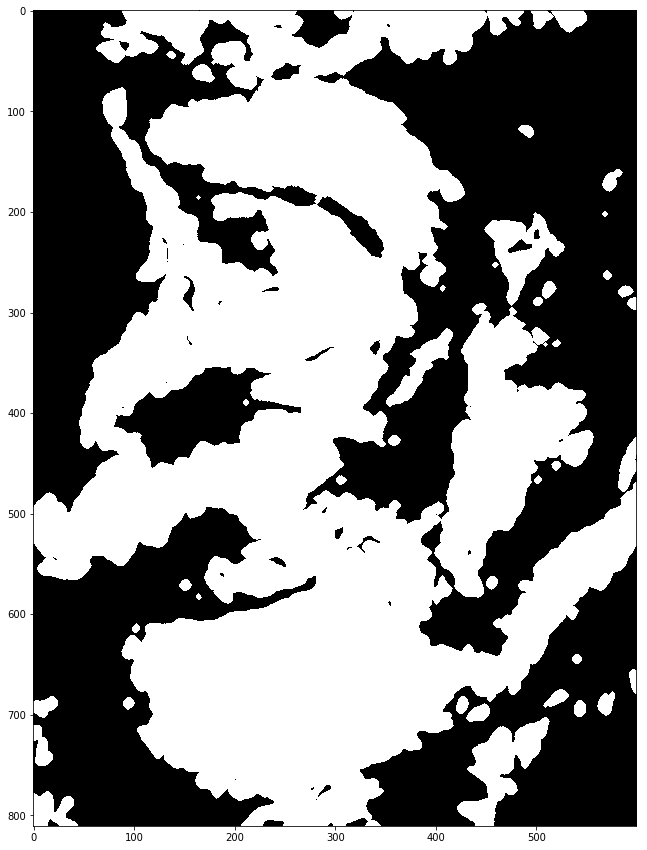

In [22]:
plot_cloud_mask(cloud_masks[image_idx])

## Using `CloudMaskRequest` to retrieve cloud masks

The `CloudMaskRequest` class allows one to retrieve cloud probability maps of an area for all available dates within a date range, and then efficiently derive binary cloud masks.

This class provides high-level functionality on top of the `S2PixelCloudDetector` cloud detector, reusing the `WmsRequest` created previously, or passing Sentinel Hub instance ID, bounding box, date range, width, and height, as well as classifier-specific parameters as input.

In [23]:
all_cloud_masks = CloudMaskRequest(ogc_request=wms_bands_request, threshold=0.1)

We can now iterate the `all_cloud_masks` object to retrieve cloud probability map, cloud mask, and the raster data for each available data in the date range. With the current `wms_bands_request`, not all necesarry colors are downloaded, but we can use the ones from `wms_true_color_request`, as long as we are comparing images of the same size and in the same time range.

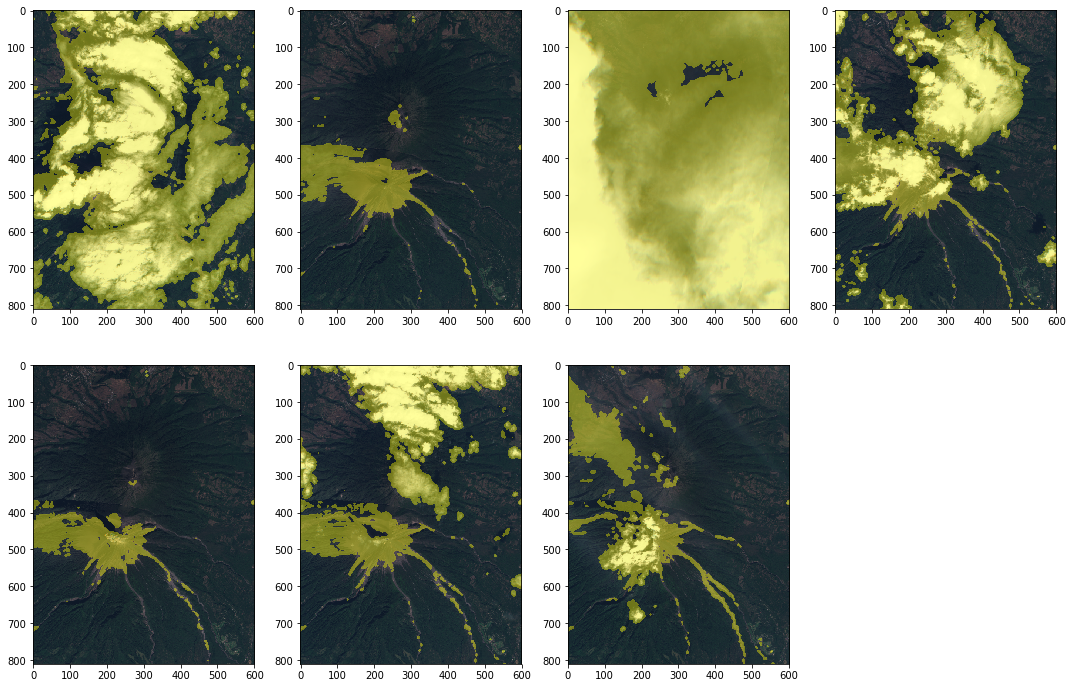

In [26]:
fig = plt.figure(figsize=(15, 10))
n_cols = 4
n_rows = int(np.ceil(len(wms_true_color_imgs) / n_cols))

for idx, [prob, mask, data] in enumerate(all_cloud_masks):
    ax = fig.add_subplot(n_rows, n_cols, idx + 1)
    image = wms_true_color_imgs[idx]
    overlay_cloud_mask(image, mask, factor=1, fig=fig)
    
plt.tight_layout()

Let's check the dates on which the data are available.

In [27]:
all_cloud_masks.get_dates()

[datetime.datetime(2017, 12, 1, 16, 38, 51),
 datetime.datetime(2017, 12, 6, 16, 32, 21),
 datetime.datetime(2017, 12, 11, 16, 39, 21),
 datetime.datetime(2017, 12, 16, 16, 39, 12),
 datetime.datetime(2017, 12, 21, 16, 39, 20),
 datetime.datetime(2017, 12, 26, 16, 36, 31),
 datetime.datetime(2017, 12, 31, 16, 39, 19)]

If the default probability threshold of `0.4` doesn't suit us we can change it to compute new binary cloud masks.

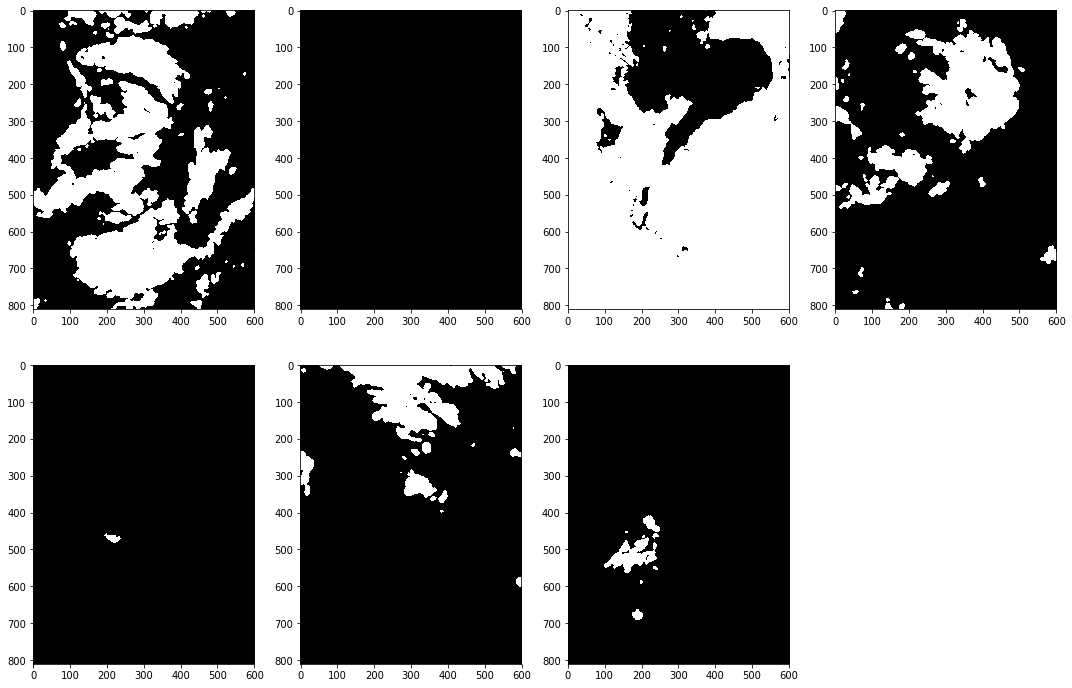

In [28]:
fig = plt.figure(figsize=(15, 10))
n_cols = 4
n_rows = int(np.ceil(len(wms_true_color_imgs) / n_cols))

for idx, cloud_mask in enumerate(all_cloud_masks.get_cloud_masks(threshold=0.7)):
    ax = fig.add_subplot(n_rows, n_cols, idx + 1)
    plot_cloud_mask(cloud_mask, fig=fig)
    
plt.tight_layout()

Compare that with the default threshold of `0.4`.

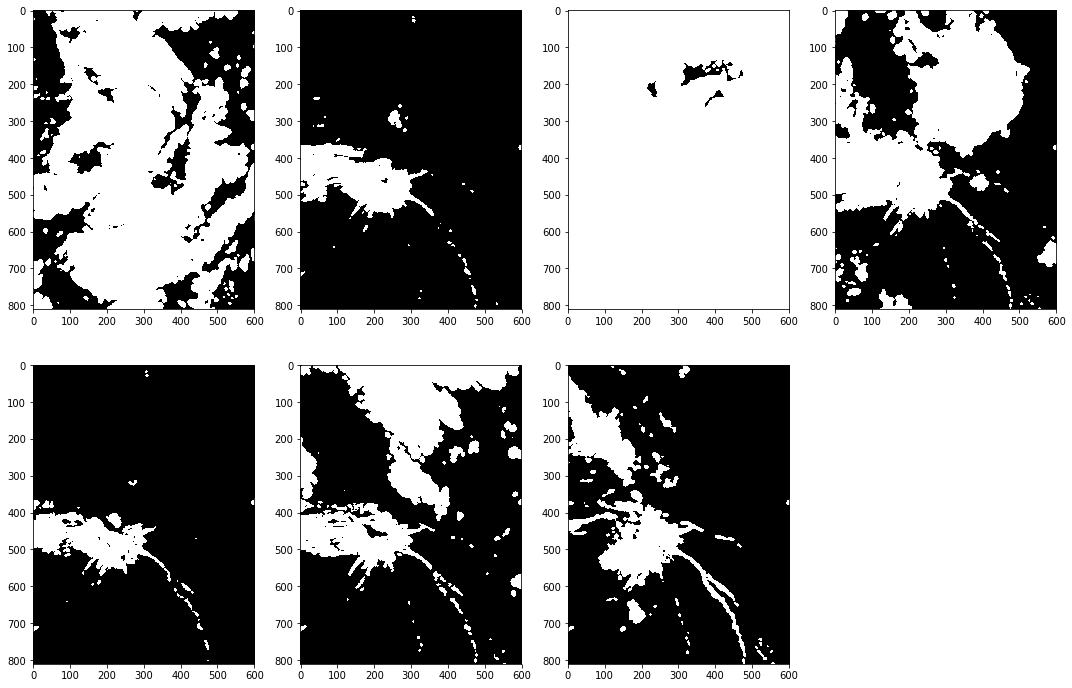

In [29]:
fig = plt.figure(figsize=(15, 10))
n_cols = 4
n_rows = int(np.ceil(len(wms_true_color_imgs) / n_cols))

for idx, cloud_mask in enumerate(all_cloud_masks.get_cloud_masks()):
    ax = fig.add_subplot(n_rows, n_cols, idx + 1)
    plot_cloud_mask(cloud_mask, fig=fig)
    
plt.tight_layout()